In [1]:
%pip install ipympl
%pip install panel
%pip install libertem_ui
%pip install jupyter_bokeh
%matplotlib widget


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import jaxgym.components as comp
from jaxgym.stemoverfocus import project_frame_backward, project_frame_forward
from jaxgym.ray import Ray

from scipy.ndimage import rotate
from scipy.ndimage import zoom
import tqdm.auto as tqdm

jax.config.update('jax_platform_name', 'cpu')

Set up the sample.

In [3]:
from jax.scipy.interpolate import RegularGridInterpolator

sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = np.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

# Set up grid coordinates corresponding to the physical centers of the pixels.
# Note: We use the rotated image’s physical edge lengths (sample_rotated_edge_length_x/y)
# to generate coordinates that match each pixel center.
sample_coords_x = np.linspace(-sample_rotated_edge_length_x/2,
                              +sample_rotated_edge_length_x/2,
                              sample_rotated.shape[1])

sample_coords_y = np.linspace(-sample_rotated_edge_length_y/2,
                              +sample_rotated_edge_length_y/2,
                              sample_rotated.shape[0])

# Flip the y-axis of the sample_rotated image
sample_rotated = np.flipud(sample_rotated)

# Build the RegularGridInterpolator
sample_interpolant = RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated,
    method='nearest', bounds_error=False, fill_value=0.0
)

extent = (
    sample_coords_x[0], sample_coords_x[-1],
    sample_coords_y[0], sample_coords_y[-1]
)

In [4]:
grid = (-sample_coords_y, sample_coords_x)

print(sample_interpolant.grid[0] + grid[0])
print(sample_interpolant.grid[1] - grid[1])

yy, xx = np.meshgrid(*grid, indexing='ij')
grid_points = np.column_stack((yy.ravel(), xx.ravel()))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
interp_image = sample_interpolant(grid_points).reshape(yy.shape)
print(np.max(interp_image))

plt.figure()
plt.imshow(np.abs(interp_image), cmap='gray', extent=extent)
plt.title("Interpolated Sample Image")
plt.xlabel("X (physical units)")
plt.ylabel("Y (physical units)")
plt.colorbar(label="Amplitude")
plt.show()

In [ ]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 

## Descan Error matrix looks like this
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix

## NO Descan ERROR matrix looks like this - Remember that Axx, and Ayy in reality should be 1 for no error, 
# but if we set them to 1 to mean no error its a bit confusing, so we have offset their value inside the descanner. 
Axx, Ayy, Cxx, Cyy = 0, 0, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
semi_conv = 0.05
defocus = 0.01
camera_length = 1.0
scan_shape = sample_image_shape
det_shape = (64, 64)
scan_step_yx = (0.0001, 0.0001)
det_px_size= (0.002, 0.002)
scan_rotation = 0

params_dict = {
    'semi_conv': semi_conv,
    'defocus': defocus, # Distance from the crossover to the sample
    'camera_length': camera_length, # Distance from the sample to the detector
    'scan_shape': scan_shape,
    'det_shape': det_shape,
    'scan_step_yx': scan_step_yx,
    'det_px_size': det_px_size,
    'scan_rotation': scan_rotation,
    'descan_error': descan_error,
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step_yx=params_dict['scan_step_yx'], scan_shape_yx=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), det_shape_yx=params_dict['det_shape'], det_pixel_size_yx=params_dict['det_px_size'])
model = [PointSource, ScanGrid, Descanner, Detector]

Scan grid over Sample sanity plot.

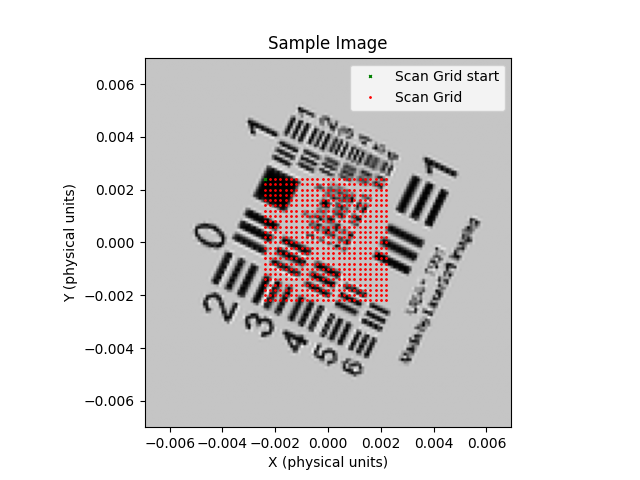

In [ ]:
scan_coordinates = ScanGrid.coords

# Reshape the scan coordinates into a 2D grid (centers of pixels).
grid = scan_coordinates.reshape(ScanGrid.scan_shape_yx[1], ScanGrid.scan_shape_yx[0], 2)

plt.figure()
plt.imshow(np.abs(interp_image), cmap='gray', extent=extent, origin='upper')
plt.plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)
plt.plot(grid[0, 0, 1], grid[0, 0, 0], 'gx', markersize=2, label='Scan Grid start')
plt.plot([], [], 'ro', markersize=1, label='Scan Grid')
plt.title('Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.legend()
plt.show()

Generating the forward dataset:

In [ ]:
fourdstem_array = np.zeros((*ScanGrid.scan_shape_yx, *Detector.det_shape_yx), dtype=np.complex64)
scan_coords_yx = ScanGrid.coords.reshape(*ScanGrid.scan_shape_yx, 2)

for y_idx in tqdm.trange(fourdstem_array.shape[0], desc='Scan Y'):
    for x_idx in range(fourdstem_array.shape[1]):
        scan_pos_yx = scan_coords_yx[y_idx, x_idx]
        det_frame = np.zeros(Detector.det_shape_yx, dtype=np.complex64)
        fourdstem_array[y_idx, x_idx] = project_frame_forward(model, det_frame, sample_interpolant, scan_pos_yx)

Scan Y:   0%|          | 0/24 [00:00<?, ?it/s]

0.0023999999 -0.0023999999


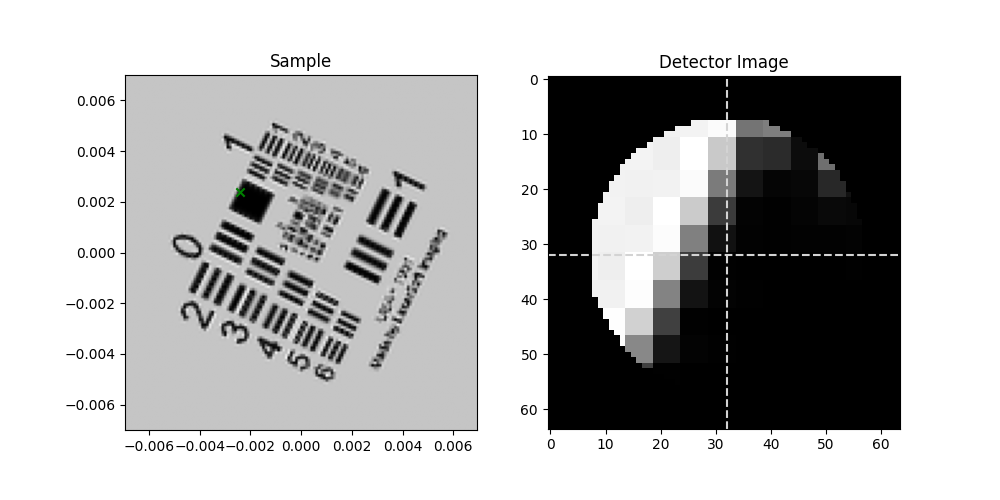

In [ ]:
scan_idx_y, scan_idx_x = 0, 0
scan_pos_y, scan_pos_x = scan_coords_yx[scan_idx_y, scan_idx_x]
print(scan_pos_y, scan_pos_x)
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(interp_image), extent=extent, cmap='gray')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.det_shape_yx[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.det_shape_yx[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

Generate the backward get_shifted_sum solution

In [ ]:
shifted_sum = np.zeros(ScanGrid.scan_shape_yx, dtype=np.complex64)
for y_idx in tqdm.trange(fourdstem_array.shape[0], desc='Scan Y'):
    for x_idx in range(fourdstem_array.shape[1]):
        scan_pos = scan_coords_yx[y_idx, x_idx]
        
        # Compute the backward projection for this scan position.
        shifted_sum += project_frame_backward(model, fourdstem_array[y_idx, x_idx], scan_pos)


Scan Y:   0%|          | 0/24 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Shifted Sum Image')

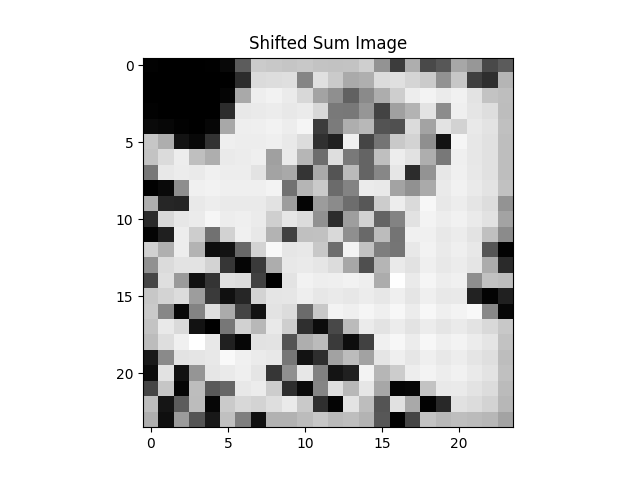

In [ ]:
plt.figure()
plt.imshow(np.abs(shifted_sum), cmap='gray')
plt.title('Shifted Sum Image')

In [ ]:
det_shape_y, det_shape_x = 106, 103
pixel_size = 0.01
extent_y = det_shape_y * pixel_size
extent_x = det_shape_x * pixel_size

# Y is positive downwards by default as per numpy array convention
y_lin = jnp.linspace(extent_y / 2,
                     -extent_y / 2,
                     det_shape_y,
                     endpoint=True)

x_lin = jnp.linspace(-extent_x / 2,
                     extent_x / 2,
                     det_shape_x)